# Sentiment Analysis

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from youtube_API_script import get_comments_in_videos, comments, youtube, video_ids
from wordcloud import WordCloud
from collections import Counter
import re

plt.style.use("ggplot")
comments = get_comments_in_videos(youtube, video_ids)

# only comments for first two video_id's
comments_ = comments[0]

print(comments_)

{'video_id': 'Z452xt_QKF0', 'comments': ['Amazing relationship with your animals .. beautiful ❤ look at her beautiful teeth too!', "it's a big cute dog", 'A genuine question, when you\'re with hyena then you\'re with lion or vice versa, didn\'t that make you a "betrayer" because you have both of their smell? Or did your hyena and lion specifically aren\'t a rival, or it because they trust you that much they didn\'t care about it? Or did you visit them on different time? \n\nI really find it interesting human can mingle with wild life and found it extremely commendable. You\'re literally an ambassador of human to wild life. Nothing but huge respect 💪', 'I love Dean and all of his beautiful furry babies!  It must be so amazing to cuddle with lions and a hyena.  🥰🥰🥰🥰🥰', 'Love is love ❤', 'Amazing work with all the animals he has. You’re so inspiring, I really wish more people can be involved with projects like this. Thanks 🙏 ❤❤❤', '❤❤❤❤❤❤❤❤❤❤❤❤❤❤', "Protect this man at all costs. He isn't

In [26]:
# creating dataframe with video_ids and their respective top 10 comments
ids = []
values = []

for item in comments:
    ids.append(item["video_id"])
    values.append(item["comments"])
    
df = pd.DataFrame(values, index=ids)

df.reset_index(inplace=True)

df.columns = ["video_id"] + [f"comment {i+1}" for i in range(len(df.columns) - 1)]
print(df.head())

      video_id                                          comment 1  \
0  Z452xt_QKF0                                     Love is love ❤   
1  pdDSkXyJKuA                     Scars full of respect - adore!   
2  lAbQMq0mH28                              He us Naruto irl☠️☠️🗿   
3  rtod4cky65Y  Thinking out loud; do they also know the camer...   
4  JP8OMII0l80                                                😢😢😢   

                                           comment 2  \
0  Amazing work with all the animals he has. You’...   
1           Are you okay? I saw you bleeding hardly.   
2  So how do you fulfil your responsibilities dur...   
3  I have a question because they are cats just r...   
4  Your are very lucky man and how did their now you   

                                           comment 3  \
0                                     ❤❤❤❤❤❤❤❤❤❤❤❤❤❤   
1                           Don't let nayla grow☠️☠️   
2  Lionssss🦁🦁🦁🦁🦁🦁♌️♌️♌️♌️♌️♌️💖💟💘💞❣️🥰💋💕👍🥰💝💝💝💕💟👌💖💕🦁...   
3  you have the life I w

In [14]:
# creating dataframe with all comments in single column
ids2 = []
values2 = []

for item in comments:
    id_value = item["video_id"]
    for value in item["comments"]:
        ids2.append(id_value)
        values2.append(value)

df = pd.DataFrame({
    "video_id" : ids2,
    "comments" : values2
})

print(df.head())

      video_id                                           comments
0  Z452xt_QKF0                                     Love is love ❤
1  Z452xt_QKF0  Amazing work with all the animals he has. You’...
2  Z452xt_QKF0                                     ❤❤❤❤❤❤❤❤❤❤❤❤❤❤
3  Z452xt_QKF0  Protect this man at all costs. He isn't a nati...
4  Z452xt_QKF0  Animales bellos y grandes desconocidos. Gracia...


In [15]:
# extracting random comment
example = df["comments"][7]
print(example)

You are so cordial 😊😊😊


### Roberta Pretrained Model

In [16]:
# import libraries
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [17]:
# retrieve pretrained model
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [18]:
# run model
encoded_text = tokenizer(example, return_tensors="pt")
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    "roberta_neg" : scores[0],
    "roberta_neu" : scores[1],
    "roberta_pos" : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.0019818223, 'roberta_neu': 0.021310234, 'roberta_pos': 0.976708}


In [19]:
# function to get scores of probabilities; not only one score but also to show tendencies
def polarity_scores_roberta(x):
    encoded_text = tokenizer(x, return_tensors="pt")
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        "roberta_neg" : scores[0],
        "roberta_neu" : scores[1],
        "roberta_pos" : scores[2]
    }
    return scores_dict

In [20]:
# testing the function
polarity_scores_roberta("I love this service.")

{'roberta_neg': 0.004184309,
 'roberta_neu': 0.010356441,
 'roberta_pos': 0.9854593}

In [21]:
# loop to run model over all comments
from tqdm.notebook import tqdm

res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row["comments"]
        myid = row["video_id"]
        roberta_result =  polarity_scores_roberta(text)
        res[myid] = {
            "content" : text,
            "result": roberta_result
        }
    except RuntimeError:
        print(f"Broke for id {myid}")

  0%|          | 0/1480 [00:00<?, ?it/s]

Broke for id ibmwsSetbBw


In [ ]:
# append scores to comment dataframe
flattened_data = []

for key, value in res.items():
    flat_entry = {
        'ID': key,
        'content': value['content'],
        'roberta_neg': value['result']['roberta_neg'],
        'roberta_neu': value['result']['roberta_neu'],
        'roberta_pos': value['result']['roberta_pos']
    }
    flattened_data.append(flat_entry)

df = pd.DataFrame(flattened_data)
print(df.head())

,ID,content,roberta_neg,roberta_neu,roberta_pos
0,Z452xt_QKF0,Never in my life would i have thought a hyena ...,0.759537,0.221230,0.019232
1,pdDSkXyJKuA,DANG THOSE SCRATCHES,0.627815,0.301108,0.071077
2,lAbQMq0mH28,It probably hurts when she licks you tho,0.685944,0.294705,0.019351
3,rtod4cky65Y,❤❤❤,0.005155,0.073942,0.920902
4,JP8OMII0l80,Naya said back up not tonight baby.,0.236934,0.722959,0.040107
...,...,...,...,...,...
143,jenVMnOi2uA,Camera man 😂,0.194679,0.491691,0.313630
144,Zynpy5RE3aU,Lion : i dont want to be viral coz eating some...,0.707003,0.275637,0.017361
145,ixkR0BirASw,he is a jumanji,0.167782,0.766932,0.065286
146,ciUJcmp1i1M,"He reminds me of Steve Irwin, the same passion...",0.002134,0.024464,0.973402


### ***ANALYSIS***

#### Overall Sentiment and distribution

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to determine the sentiment category, sentiments with highest scores gets selected
def determine_sentiment(row):
    sentiments = {"neg": row["roberta_neg"], "neu": row["roberta_neu"], "pos": row["roberta_pos"]}
    return max(sentiments, key=sentiments.get)

# Add a new column for the sentiment category and print
df["overall_sentiment"] = df.apply(determine_sentiment, axis=1)
df_overall_sentiment = df.drop(columns=["roberta_pos", "roberta_neu", "roberta_neg"])
print(df_overall_sentiment.head())

,ID,content,overall_sentiment
0,Z452xt_QKF0,Never in my life would i have thought a hyena ...,neg
1,pdDSkXyJKuA,DANG THOSE SCRATCHES,neg
2,lAbQMq0mH28,It probably hurts when she licks you tho,neg
3,rtod4cky65Y,❤❤❤,pos
4,JP8OMII0l80,Naya said back up not tonight baby.,neu
...,...,...,...
143,jenVMnOi2uA,Camera man 😂,neu
144,Zynpy5RE3aU,Lion : i dont want to be viral coz eating some...,neg
145,ixkR0BirASw,he is a jumanji,neu
146,ciUJcmp1i1M,"He reminds me of Steve Irwin, the same passion...",pos



Sentiment Distribution:
overall_sentiment
pos    78
neu    42
neg    28
Name: count, dtype: int64


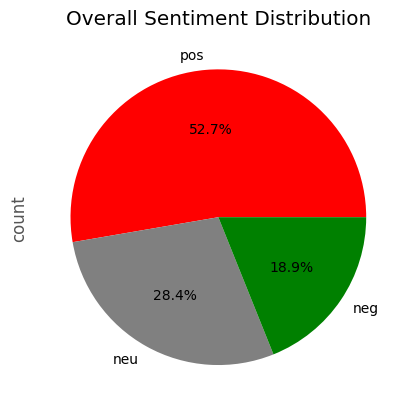

In [ ]:
# Analyze sentiment distribution
sentiment_distribution = df["overall_sentiment"].value_counts()
print("\nSentiment Distribution:")
print(sentiment_distribution)

# Plot sentiment distribution
sentiment_distribution.plot(kind="pie", autopct="%1.1f%%", colors=["red", "gray", "green"])
plt.title("Overall Sentiment Distribution")
plt.show()

#### Extreme Sentiments

In [ ]:
# ranking comments by score in order  to get most positive/negative
positive_comments = df[df["overall_sentiment"] == "pos"]
negative_comments = df[df["overall_sentiment"] == "neg"]

print("\nMost Positive Comments:")
print(positive_comments[["ID", "content"]])

print("\nMost Negative Comments:")
print(negative_comments[["ID", "content"]])


Most Positive Comments:
              ID                                            content
3    rtod4cky65Y                                                ❤❤❤
5    0ER-UpWZcLk  Wish to see you in person, here in our proud c...
6    0N82gpER4XU  I was there! And it was so much fun I even got...
8    fdbgHBb4EkM                                          great guy
10   AhfarJFKBj4  So dramatic for no reason like why but I’m lov...
..           ...                                                ...
138  DAbruroD-K4  Them lions genuinely love him it's dedication ...
139  x15fkhih3qQ  The biggest value you can contribute to this w...
141  A-qPhvwESvI  Handsome dean schneider, i super enjoying watc...
142  eEkl2IVoYyc                               Thank you doctor. ❤🙏
146  ciUJcmp1i1M  He reminds me of Steve Irwin, the same passion...

[78 rows x 2 columns]

Most Negative Comments:
              ID                                            content
0    Z452xt_QKF0  Never in my life would i 

#### Common words

In [ ]:
# Combine all comments
all_comments = " ".join(df["content"])

# Define stopwords language
stop_words = set(stopwords.words("english"))

# Basic word frequency analysis (excluding common stop words) comparing to with and without stopwords
words_before = re.findall(r'\w+', all_comments.lower())
common_words_before = Counter(words_before).most_common(10)
print("\nCommon Words in Comments BEFORE:")
print(common_words_before)

words = [word for word in re.findall(r'\w+', all_comments.lower()) if word not in stop_words]
common_words = Counter(words).most_common(10)
print("\n\nCommon Words in Comments:")
print(common_words)



Common Words in Comments BEFORE:
[('the', 49), ('i', 47), ('a', 43), ('to', 41), ('you', 40), ('and', 30), ('it', 24), ('is', 23), ('this', 22), ('so', 20)]


Common Words in Comments:
[('love', 20), ('dean', 18), ('like', 14), ('get', 9), ('lion', 8), ('beautiful', 7), ('man', 7), ('would', 6), ('much', 6), ('really', 6)]


### Wordcloud

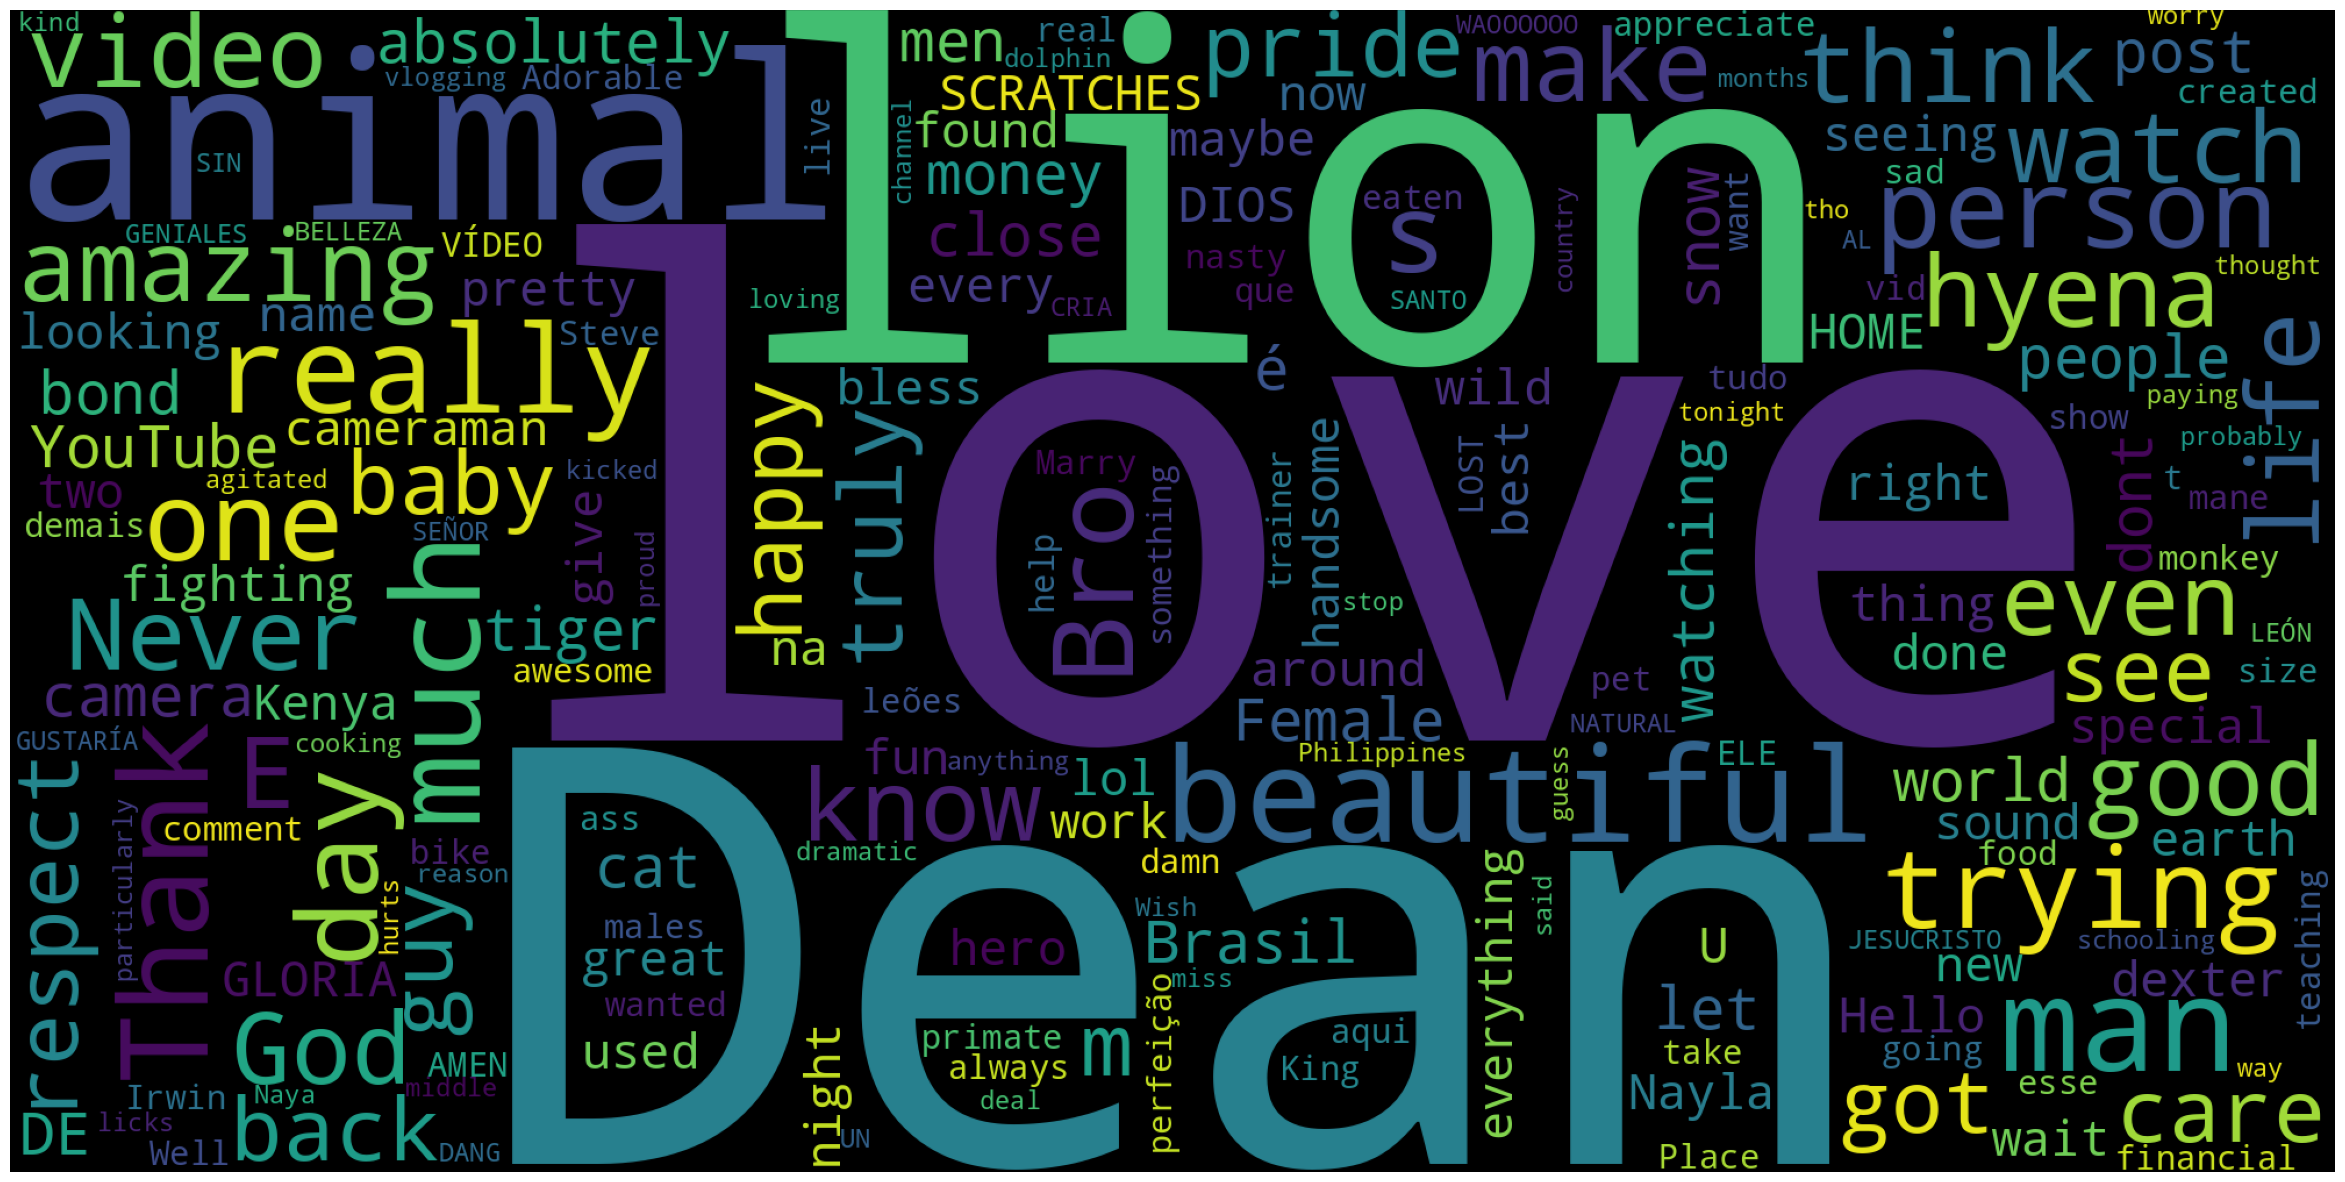

In [ ]:
# Define stopwords language
stop_words = set(stopwords.words("english"))

# remove stopwords
df["comments_no_stopwords"] = df["content"].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

# all words into one string
all_words = list([a for b in df["comments_no_stopwords"].tolist() for a in b])
all_words_str = " ".join(all_words)

# function to plot wordcloud
def plot_cloud(wordcloud):
    plt.figure(figsize=(30,20))
    plt.imshow(wordcloud)
    plt.axis("off");

# generating wordcloud and apply function
wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color="black", colormap="viridis", collocations=False).generate(all_words_str)
plot_cloud(wordcloud)